In [72]:
from GridCell import GridCell
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from tqdm import notebook
import pandas as pd

Flow direction algorithm of Donnel et. al., 1999 require two inputs -
1. Flow Accumulation file - This can be generated from a fine resolution DEM by following [these steps in QGIS](https://docs.qgis.org/2.8/en/docs/training_manual/processing/hydro.html) or [these steps in ArcGIS](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/flow-accumulation.htm).
2. Grid file - This file discretizes the basin of interest into Grid-cells of suitable size. This can be generated using the [grid tool in QGIS](https://docs.qgis.org/2.6/en/docs/user_manual/processing_algs/qgis/vector_creation_tools/creategrid.html) or using the [fishnet tool in ArcGIS](https://desktop.arcgis.com/en/arcmap/10.3/tools/data-management-toolbox/create-fishnet.htm).

Both of the datasets are generated separately and are present in the `data` subdirectory. Let's read in both the datasets, and plot them!

Text(0.5, 1.0, 'Mekong Grid $0.0625°$')

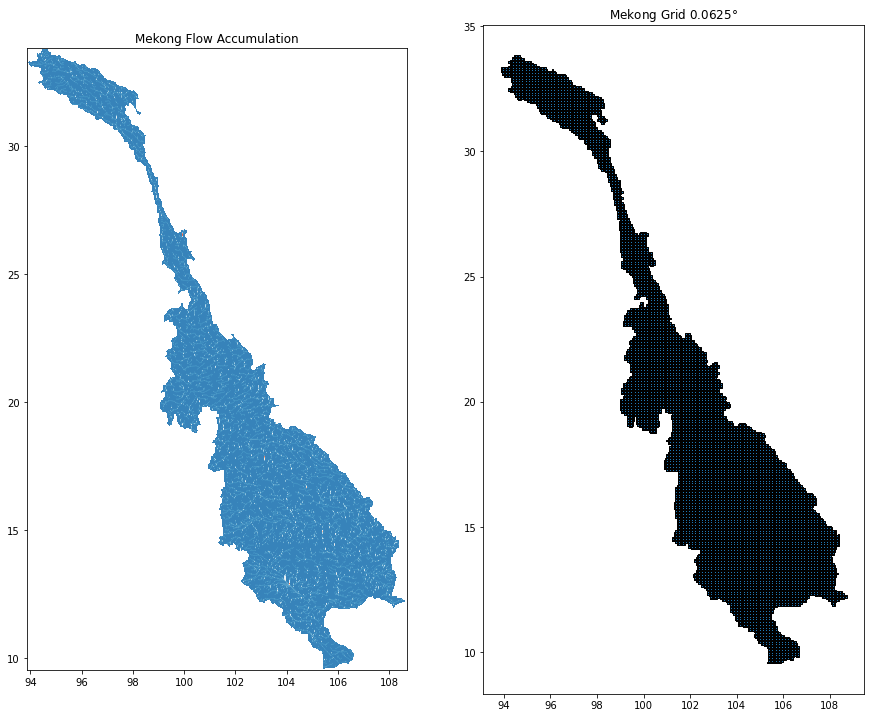

In [46]:
flowacc_path = 'data/mekong_flowaccumulation.tif'
flowacc_rast = rio.open(flowacc_path)

gdf = gpd.read_file('data/mekong_grid.shp')

fig, ax = plt.subplots(ncols=2, figsize=(15, 15))
flowacc = flowacc_rast.read(1, masked=True)
show(flowacc>10e3, transform=flowacc_rast.transform, cmap='RdBu_r', vmin=-0.1, vmax=0.5, ax=ax[0])
gdf.plot(ax=ax[1], edgecolor='k')
ax[0].set_title("Mekong Flow Accumulation")
ax[1].set_title("Mekong Grid $0.0625°$")

A stream network can easily be generated from flow accumulation file. In the above plot, the pixels where more than 1000 upstream pixels flow into are highlighted as a brighter color, which represents the Mekong Stream network. To the right, the mekong Grid file is plotted, which is created for a cell size of $0.0625°$.

Let's now generate the directions for the hydrologic grid.

In [50]:
# Save the results in a dictionary, so that it can later be converted to to a pandas dataframe.
# This dataframe can then be converted into a geopandas GeoDataFrame which is but a specialized
# pandas dataframe, that is used to store Vector data.
exits = {
    'i': [],
    'x': [],
    'y': [],
    'clean_exit': [],
    'dir': [],
    'id': []
}

# Extra ✨aesthetic✨ -> Show progress using a progressbar 
with notebook.tqdm(total=gdf.shape[0]) as pbar:
    for i in range(gdf.shape[0]):
        gc = GridCell(gdf.iloc[i, :], flowacc_rast)
        exits['id'].append(gdf.loc[i, ["OBJECTID"]].values[0])
        exits['i'].append(i)
        exits['x'].append(gc.exit[0])
        exits['y'].append(gc.exit[1])
        exits['clean_exit'].append(gc.clean_exit())
        exits['dir'].append(gc.determine_direction())
        pbar.update(1)
        pbar.set_description(f'{i:05}: ({gc.exit[0]:03}, {gc.exit[1]:03}): {gc.clean_exit()} - {gc.griddirection}')

  0%|          | 0/18217 [00:00<?, ?it/s]

Now that we have a dictionary containing the information we need, let's convert it to a pandas dataframe

In [52]:
df = pd.DataFrame(exits)
df.head()

,i,x,y,clean_exit,dir,id
0,0,70,74,True,5,184
1,1,68,44,False,0,185
2,2,31,0,True,7,186
3,3,49,57,False,0,187
4,4,44,45,False,0,188


Here we can see the the `id` is the ID of the grid cell. This can be used to join it to the original vector dataset. 

`x` and `y` tell us about the index of the exit point.

`dir` is the determined gridcell direction.

`clean_exit` considers an exit point 'clean', if the exit point is at the edge of the grid cell. In some cases (generally when large portion of the cell is covered by a river) the flow-accumulation data can mislead. Let's look at the ratio of clean to dirty exits.

In [55]:
df.groupby('clean_exit').count()

,i,x,y,dir,id
clean_exit,,,,,
False,337,337,337,337,337
True,17880,17880,17880,17880,17880


There are 337 dirty exits, as compared to 17880 clean ones. This equates to <2% of the cell exits being dirty - which seems reasonably acceptable.

Let's now join the determined results with the original shapefile, which will give us a Hydrological grid with the determined grids.

In [58]:
result = pd.merge(df, gdf, left_on='id', right_on='OBJECTID')[['i', 'x', 'y', 'dir', 'geometry']]

result_grid = gpd.GeoDataFrame(result)
result_grid.head()

,i,x,y,dir,geometry
0,0,70,74,5,"POLYGON ((105.29958 9.54375, 105.29958 9.60625..."
1,1,68,44,0,"POLYGON ((105.36208 9.54375, 105.36208 9.60625..."
2,2,31,0,7,"POLYGON ((105.42458 9.54375, 105.42458 9.60625..."
3,3,49,57,0,"POLYGON ((105.48708 9.54375, 105.48708 9.60625..."
4,4,44,45,0,"POLYGON ((105.54958 9.54375, 105.54958 9.60625..."


Now that we have the calculated directions, let's plot it and see it the directions make sense.

[Text(1, 0.5, 'N'),
 Text(1, 1.5, 'NE'),
 Text(1, 2.5, 'E'),
 Text(1, 3.5, 'SE'),
 Text(1, 4.5, 'S'),
 Text(1, 5.5, 'SW'),
 Text(1, 6.5, 'W'),
 Text(1, 7.5, 'NW')]

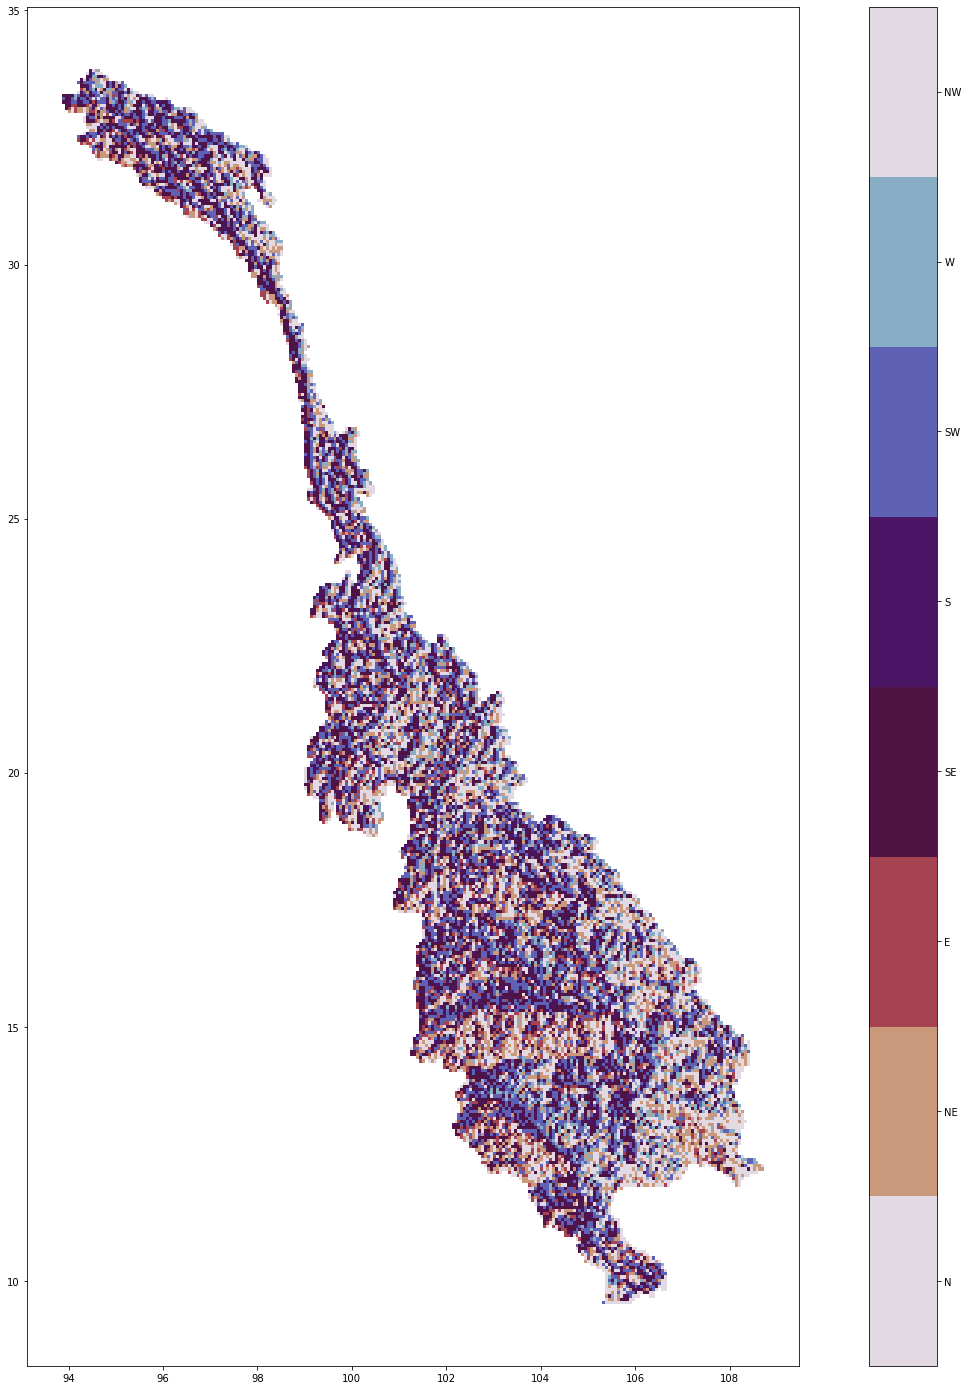

In [80]:
fig, ax = plt.subplots(figsize=(25,25))
norm = Normalize(vmin=result_grid.dir.min(), vmax=result_grid.dir.max())

cmap = plt.cm.get_cmap('twilight_r', 8)

cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

im = result_grid.plot(column='dir', cmap=cmap, ax=ax, legend=False)
ax_cbar = fig.colorbar(cbar, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5])
# add label for the colorbar
# ax_cbar.set_label('I am a label')
ax_cbar.ax.set_yticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

An initial assessment suggests that the directions do in fact correspond to the actual flow directions for that cell. Further assessment using a GIS software, it becomes clear that the determined directions are fairly accurate, and follow the direction in which the stream/river flows.